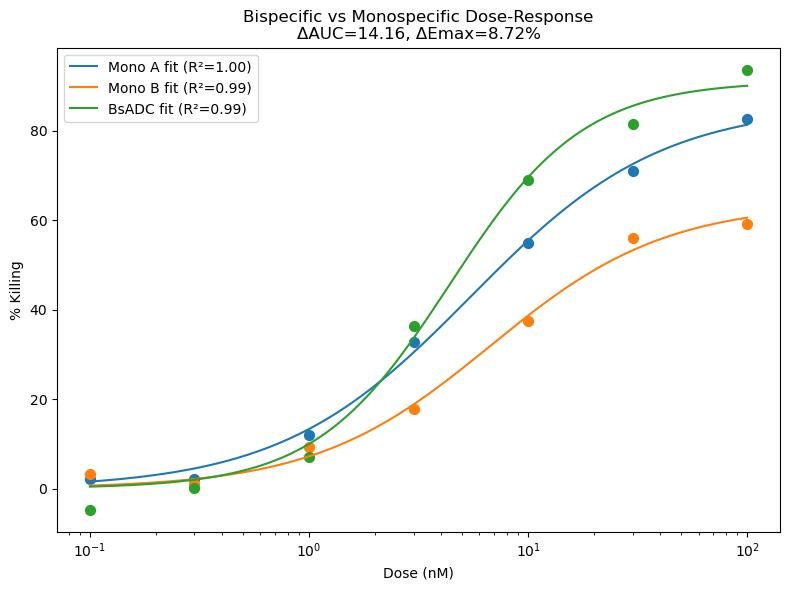

In [7]:
import numpy as np
from scipy.optimize import curve_fit
from scipy.integrate import simpson
import matplotlib.pyplot as plt

np.random.seed(42)  # for reproducibility

def hill(x, Emax, EC50, n):
    return Emax * x**n / (EC50**n + x**n)

dose = np.array([0.1, 0.3, 1, 3, 10, 30, 100])

# Generate noisy responses
true_params = {
    'Mono A': [80, 5, 1.2],
    'Mono B': [70, 8, 1.0],
    'BsADC': [90, 4, 1.5]
}

responses = {}
for name, (Emax, EC50, n) in true_params.items():
    clean = hill(dose, Emax, EC50, n)
    noise = np.random.normal(0, 3, size=dose.shape)  # ±3% noise
    responses[name] = clean + noise

# Fit Hill curves and calculate R²
fits, r2_scores, aucs, emax_values = {}, {}, {}, {}
for name, resp in responses.items():
    p0 = [100, 10, 1]
    bounds = ([0,0,0],[100,1000,5])
    popt, _ = curve_fit(hill, dose, resp, p0=p0, bounds=bounds)
    fits[name] = popt
    residuals = resp - hill(dose, *popt)
    r2_scores[name] = 1 - np.sum(residuals**2)/np.sum((resp - np.mean(resp))**2)
    aucs[name] = simpson(hill(dose, *popt), x=np.log10(dose))
    emax_values[name] = max(hill(dose, *popt))

# Synergy metrics
delta_auc = aucs['BsADC'] - max(aucs['Mono A'], aucs['Mono B'])
delta_emax = emax_values['BsADC'] - max(emax_values['Mono A'], emax_values['Mono B'])

# Plot
dose_range = np.logspace(np.log10(dose.min()), np.log10(dose.max()), 200)
plt.figure(figsize=(8,6))
for name, popt in fits.items():
    plt.plot(dose_range, hill(dose_range, *popt), label=f'{name} fit (R²={r2_scores[name]:.2f})')
    plt.scatter(dose, responses[name], s=50)
plt.xscale('log')
plt.xlabel('Dose (nM)')
plt.ylabel('% Killing')
plt.title(f'Bispecific vs Monospecific Dose-Response\nΔAUC={delta_auc:.2f}, ΔEmax={delta_emax:.2f}%')
plt.legend()
plt.tight_layout()
plt.show()